<a href="https://colab.research.google.com/github/anilbhatt1/Deep_Learning_EVA4_Phase1/blob/master/EVA4_S6_With_L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np

## Data Transformations



In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                                       transforms.RandomRotation((-7,7),fill=(1,)),
                                      #  transforms.RandomHorizontalFlip(),
                                      #  transforms.RandomErasing(p=0.2), 
                                       transforms.ToTensor(),                                       
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

# Dataset and Creating Train/Test Split

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 28x28x1 , out = 26x26x16, RF = 3

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 26x26x16 , out = 24x24x16, RF = 5
 
        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # in = 24x24x16 , out = 12x12x16, RF = 6

        # CONVOLUTION BLOCK 2
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 12x12x16 , out = 10x10x16, RF = 10
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 10x10x16 , out = 8x8x16, RF = 14

        # OUTPUT BLOCK
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # in = 8x8x16 , out = 6x6x16, RF = 18
        self.Gap1 = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # in = 6x6x16 , out = 1x1x16, RF = 28	
        self.fc1 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # in = 1x1x16 , out = 1x1x10, RF = 28

    def forward(self, x):
        x = self.convblock2(self.convblock1(x))
        x = self.pool1(x)
        x = self.convblock4(self.convblock3(x))
        x = self.Gap1(self.convblock5(x))
        x = self.fc1(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params


In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           2,304
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

# Training and Testing

In [0]:
from tqdm import tqdm

actual_img = []
wrong_pred = []
actual_target = []     

def train(model, device, train_loader, optimizer, epoch, factor):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  i = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    
    L1_Crit = nn.L1Loss(size_average=None, reduce=None, reduction='mean')
    reg_loss = 0 
    for param in model.parameters():
      zero_vector = torch.rand_like(param) * 0
      reg_loss += L1_Crit(param,zero_vector)
    loss += factor * reg_loss
    
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    # in view() method the shape of the desired output tensor is to be passed in as the parameter,
    # whereas in view_as() a tensor whose shape is to be mimicked it passed.
    # tensor.view_as(other) is equivalent to tensor.view(other.size())
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Train Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)
    if batch_idx == 468:
      train_acc_epoch.append(100*correct/processed)
      train_losses_epoch.append(loss)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    i = 0
    with torch.no_grad():

        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            idx_incorrect = pred.ne(target.view_as(pred)).view(-1)
            actual_img.append(data[idx_incorrect.nonzero()].cpu().numpy())
            wrong_pred.append(pred[idx_incorrect.nonzero()].cpu().numpy())
            actual_target.append(target[idx_incorrect.nonzero()].cpu().numpy())
            
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Test Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Running the Model with L2

  0%|          | 0/469 [00:00<?, ?it/s]


<<<<<<<< With L2 >>>>>>>>
----------L2_Factor--------: 0.0005
EPOCH: 0


Loss=0.08524060249328613 Batch_id=468 Train Accuracy=91.45: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Test Accuracy: 9846/10000 (98.46%)

EPOCH: 1


Loss=0.017314821481704712 Batch_id=468 Train Accuracy=98.11: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Test Accuracy: 9856/10000 (98.56%)

EPOCH: 2


Loss=0.05349472537636757 Batch_id=468 Train Accuracy=98.45: 100%|██████████| 469/469 [00:26<00:00, 17.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Test Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.06871960312128067 Batch_id=468 Train Accuracy=98.62: 100%|██████████| 469/469 [00:26<00:00, 17.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 4


Loss=0.019266797229647636 Batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:25<00:00, 22.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9915/10000 (99.15%)

EPOCH: 5


Loss=0.058611560612916946 Batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:26<00:00, 18.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.04241877421736717 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 7


Loss=0.011065502651035786 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 8


Loss=0.05365639925003052 Batch_id=468 Train Accuracy=98.98: 100%|██████████| 469/469 [00:25<00:00, 22.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 9


Loss=0.050112973898649216 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Test Accuracy: 9928/10000 (99.28%)

EPOCH: 10


Loss=0.038999732583761215 Batch_id=468 Train Accuracy=98.99: 100%|██████████| 469/469 [00:25<00:00, 18.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 11


Loss=0.023537732660770416 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0345, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 12


Loss=0.01644313521683216 Batch_id=468 Train Accuracy=99.00: 100%|██████████| 469/469 [00:24<00:00, 18.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 13


Loss=0.012984697706997395 Batch_id=468 Train Accuracy=98.97: 100%|██████████| 469/469 [00:24<00:00, 19.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0281, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 14


Loss=0.014108051545917988 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=0.019894016906619072 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 18.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0272, Test Accuracy: 9919/10000 (99.19%)

EPOCH: 16


Loss=0.02176322042942047 Batch_id=468 Train Accuracy=99.02: 100%|██████████| 469/469 [00:25<00:00, 24.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 17


Loss=0.024074843153357506 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Test Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.006860007997602224 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 19


Loss=0.07066947966814041 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 20


Loss=0.02597237192094326 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 21


Loss=0.05446332320570946 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0302, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 22


Loss=0.01847699284553528 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:23<00:00, 19.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 23


Loss=0.048951223492622375 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0260, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 24


Loss=0.050006214529275894 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 25


Loss=0.011537119746208191 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:24<00:00, 19.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9925/10000 (99.25%)

EPOCH: 26


Loss=0.004627550486475229 Batch_id=468 Train Accuracy=99.12: 100%|██████████| 469/469 [00:25<00:00, 21.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9936/10000 (99.36%)

EPOCH: 27


Loss=0.03281307592988014 Batch_id=468 Train Accuracy=99.06: 100%|██████████| 469/469 [00:25<00:00, 18.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 28


Loss=0.07165034115314484 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:26<00:00, 17.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 29


Loss=0.012976746074855328 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 30


Loss=0.1026049256324768 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:25<00:00, 18.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 31


Loss=0.03455907478928566 Batch_id=468 Train Accuracy=99.09: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0311, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 32


Loss=0.027749687433242798 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 33


Loss=0.02363651990890503 Batch_id=468 Train Accuracy=99.10: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Test Accuracy: 9916/10000 (99.16%)

EPOCH: 34


Loss=0.046882111579179764 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Test Accuracy: 9902/10000 (99.02%)

EPOCH: 35


Loss=0.020469725131988525 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0259, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 36


Loss=0.04404449462890625 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Test Accuracy: 9927/10000 (99.27%)

EPOCH: 37


Loss=0.04360448196530342 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Test Accuracy: 9918/10000 (99.18%)

EPOCH: 38


Loss=0.019801676273345947 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 39


Loss=0.07696752995252609 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]



Test set: Average loss: 0.0287, Test Accuracy: 9906/10000 (99.06%)


Maxium test accuracy: 99.36, Achieved in epoch: 26, Max Train accuracy : 99.17, Achieved in epoch : 39

----------L2_Factor--------: 0.005


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.11244199424982071 Batch_id=468 Train Accuracy=91.75: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0920, Test Accuracy: 9809/10000 (98.09%)

EPOCH: 1


Loss=0.14003470540046692 Batch_id=468 Train Accuracy=97.85: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Test Accuracy: 9797/10000 (97.97%)

EPOCH: 2


Loss=0.08011948317289352 Batch_id=468 Train Accuracy=98.03: 100%|██████████| 469/469 [00:25<00:00, 18.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0850, Test Accuracy: 9830/10000 (98.30%)

EPOCH: 3


Loss=0.1325893998146057 Batch_id=468 Train Accuracy=98.01: 100%|██████████| 469/469 [00:25<00:00, 18.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0720, Test Accuracy: 9861/10000 (98.61%)

EPOCH: 4


Loss=0.0533437617123127 Batch_id=468 Train Accuracy=98.08: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0663, Test Accuracy: 9855/10000 (98.55%)

EPOCH: 5


Loss=0.11583290249109268 Batch_id=468 Train Accuracy=98.18: 100%|██████████| 469/469 [00:25<00:00, 18.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1001, Test Accuracy: 9764/10000 (97.64%)

EPOCH: 6


Loss=0.07102842628955841 Batch_id=468 Train Accuracy=98.08: 100%|██████████| 469/469 [00:25<00:00, 18.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1001, Test Accuracy: 9776/10000 (97.76%)

EPOCH: 7


Loss=0.0449146069586277 Batch_id=468 Train Accuracy=98.11: 100%|██████████| 469/469 [00:24<00:00, 19.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0722, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 8


Loss=0.11271881312131882 Batch_id=468 Train Accuracy=98.09: 100%|██████████| 469/469 [00:24<00:00, 18.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Test Accuracy: 9870/10000 (98.70%)

EPOCH: 9


Loss=0.08331777155399323 Batch_id=468 Train Accuracy=98.21: 100%|██████████| 469/469 [00:24<00:00, 19.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0912, Test Accuracy: 9800/10000 (98.00%)

EPOCH: 10


Loss=0.04435724392533302 Batch_id=468 Train Accuracy=98.24: 100%|██████████| 469/469 [00:24<00:00, 19.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0800, Test Accuracy: 9826/10000 (98.26%)

EPOCH: 11


Loss=0.0470234714448452 Batch_id=468 Train Accuracy=98.23: 100%|██████████| 469/469 [00:24<00:00, 24.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1233, Test Accuracy: 9739/10000 (97.39%)

EPOCH: 12


Loss=0.12064263969659805 Batch_id=468 Train Accuracy=98.18: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1545, Test Accuracy: 9585/10000 (95.85%)

EPOCH: 13


Loss=0.07125528901815414 Batch_id=468 Train Accuracy=98.19: 100%|██████████| 469/469 [00:24<00:00, 18.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Test Accuracy: 9868/10000 (98.68%)

EPOCH: 14


Loss=0.06725304573774338 Batch_id=468 Train Accuracy=98.19: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0843, Test Accuracy: 9824/10000 (98.24%)

EPOCH: 15


Loss=0.14419493079185486 Batch_id=468 Train Accuracy=98.27: 100%|██████████| 469/469 [00:24<00:00, 19.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Test Accuracy: 9873/10000 (98.73%)

EPOCH: 16


Loss=0.06907542794942856 Batch_id=468 Train Accuracy=98.22: 100%|██████████| 469/469 [00:24<00:00, 18.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0738, Test Accuracy: 9824/10000 (98.24%)

EPOCH: 17


Loss=0.08234179764986038 Batch_id=468 Train Accuracy=98.19: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0805, Test Accuracy: 9812/10000 (98.12%)

EPOCH: 18


Loss=0.04667370393872261 Batch_id=468 Train Accuracy=98.22: 100%|██████████| 469/469 [00:24<00:00, 19.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0686, Test Accuracy: 9844/10000 (98.44%)

EPOCH: 19


Loss=0.07841522246599197 Batch_id=468 Train Accuracy=98.29: 100%|██████████| 469/469 [00:25<00:00, 18.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0739, Test Accuracy: 9846/10000 (98.46%)

EPOCH: 20


Loss=0.10392504930496216 Batch_id=468 Train Accuracy=98.22: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0823, Test Accuracy: 9829/10000 (98.29%)

EPOCH: 21


Loss=0.1796644926071167 Batch_id=468 Train Accuracy=98.23: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1058, Test Accuracy: 9728/10000 (97.28%)

EPOCH: 22


Loss=0.11147483438253403 Batch_id=468 Train Accuracy=98.24: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0905, Test Accuracy: 9782/10000 (97.82%)

EPOCH: 23


Loss=0.0784829780459404 Batch_id=468 Train Accuracy=98.17: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0806, Test Accuracy: 9823/10000 (98.23%)

EPOCH: 24


Loss=0.07349186390638351 Batch_id=468 Train Accuracy=98.18: 100%|██████████| 469/469 [00:24<00:00, 18.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0724, Test Accuracy: 9845/10000 (98.45%)

EPOCH: 25


Loss=0.0694679394364357 Batch_id=468 Train Accuracy=98.18: 100%|██████████| 469/469 [00:25<00:00, 18.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0921, Test Accuracy: 9761/10000 (97.61%)

EPOCH: 26


Loss=0.06519149243831635 Batch_id=468 Train Accuracy=98.22: 100%|██████████| 469/469 [00:25<00:00, 18.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0597, Test Accuracy: 9870/10000 (98.70%)

EPOCH: 27


Loss=0.09587063640356064 Batch_id=468 Train Accuracy=98.20: 100%|██████████| 469/469 [00:26<00:00, 17.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0602, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 28


Loss=0.10834217071533203 Batch_id=468 Train Accuracy=98.13: 100%|██████████| 469/469 [00:25<00:00, 18.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0786, Test Accuracy: 9800/10000 (98.00%)

EPOCH: 29


Loss=0.06691113859415054 Batch_id=468 Train Accuracy=98.23: 100%|██████████| 469/469 [00:25<00:00, 21.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Test Accuracy: 9840/10000 (98.40%)

EPOCH: 30


Loss=0.1204623207449913 Batch_id=468 Train Accuracy=98.28: 100%|██████████| 469/469 [00:25<00:00, 18.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0826, Test Accuracy: 9796/10000 (97.96%)

EPOCH: 31


Loss=0.07580427080392838 Batch_id=468 Train Accuracy=98.25: 100%|██████████| 469/469 [00:25<00:00, 22.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1150, Test Accuracy: 9739/10000 (97.39%)

EPOCH: 32


Loss=0.14518038928508759 Batch_id=468 Train Accuracy=98.26: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0623, Test Accuracy: 9867/10000 (98.67%)

EPOCH: 33


Loss=0.09164262562990189 Batch_id=468 Train Accuracy=98.28: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0744, Test Accuracy: 9834/10000 (98.34%)

EPOCH: 34


Loss=0.05644703283905983 Batch_id=468 Train Accuracy=98.13: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Test Accuracy: 9834/10000 (98.34%)

EPOCH: 35


Loss=0.13322386145591736 Batch_id=468 Train Accuracy=98.35: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1475, Test Accuracy: 9604/10000 (96.04%)

EPOCH: 36


Loss=0.0565037727355957 Batch_id=468 Train Accuracy=98.33: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Test Accuracy: 9848/10000 (98.48%)

EPOCH: 37


Loss=0.05239439383149147 Batch_id=468 Train Accuracy=98.30: 100%|██████████| 469/469 [00:25<00:00, 18.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Test Accuracy: 9826/10000 (98.26%)

EPOCH: 38


Loss=0.1145498976111412 Batch_id=468 Train Accuracy=98.21: 100%|██████████| 469/469 [00:25<00:00, 18.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0830, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 39


Loss=0.09059035032987595 Batch_id=468 Train Accuracy=98.25: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]



Test set: Average loss: 0.0854, Test Accuracy: 9832/10000 (98.32%)


Maxium test accuracy: 98.73, Achieved in epoch: 15, Max Train accuracy : 98.35, Achieved in epoch : 35

----------L2_Factor--------: 0.0001


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.072421595454216 Batch_id=468 Train Accuracy=91.64: 100%|██████████| 469/469 [00:25<00:00, 18.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0645, Test Accuracy: 9820/10000 (98.20%)

EPOCH: 1


Loss=0.039523880928754807 Batch_id=468 Train Accuracy=98.06: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Test Accuracy: 9874/10000 (98.74%)

EPOCH: 2


Loss=0.11830135434865952 Batch_id=468 Train Accuracy=98.45: 100%|██████████| 469/469 [00:24<00:00, 18.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Test Accuracy: 9895/10000 (98.95%)

EPOCH: 3


Loss=0.02807958982884884 Batch_id=468 Train Accuracy=98.61: 100%|██████████| 469/469 [00:25<00:00, 18.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Test Accuracy: 9908/10000 (99.08%)

EPOCH: 4


Loss=0.014522150158882141 Batch_id=468 Train Accuracy=98.81: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 5


Loss=0.01679324172437191 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:24<00:00, 22.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.017636343836784363 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:24<00:00, 19.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 7


Loss=0.02707379125058651 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 8


Loss=0.06779935210943222 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:24<00:00, 19.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9921/10000 (99.21%)

EPOCH: 9


Loss=0.024458730593323708 Batch_id=468 Train Accuracy=99.01: 100%|██████████| 469/469 [00:25<00:00, 18.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 10


Loss=0.06199171021580696 Batch_id=468 Train Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 11


Loss=0.009181107394397259 Batch_id=468 Train Accuracy=99.08: 100%|██████████| 469/469 [00:25<00:00, 18.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Test Accuracy: 9926/10000 (99.26%)

EPOCH: 12


Loss=0.028594380244612694 Batch_id=468 Train Accuracy=99.11: 100%|██████████| 469/469 [00:24<00:00, 19.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.051655661314725876 Batch_id=468 Train Accuracy=99.17: 100%|██████████| 469/469 [00:24<00:00, 19.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 14


Loss=0.02363092638552189 Batch_id=468 Train Accuracy=99.14: 100%|██████████| 469/469 [00:24<00:00, 19.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 15


Loss=0.009111980907619 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:24<00:00, 19.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 16


Loss=0.004191845655441284 Batch_id=468 Train Accuracy=99.21: 100%|██████████| 469/469 [00:23<00:00, 19.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Test Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.048606082797050476 Batch_id=468 Train Accuracy=99.18: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0212, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 18


Loss=0.003955493215471506 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:25<00:00, 18.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 19


Loss=0.01602105237543583 Batch_id=468 Train Accuracy=99.30: 100%|██████████| 469/469 [00:24<00:00, 19.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 20


Loss=0.0526239238679409 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:26<00:00, 21.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0207, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 21


Loss=0.018125662580132484 Batch_id=468 Train Accuracy=99.24: 100%|██████████| 469/469 [00:26<00:00, 21.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9940/10000 (99.40%)

EPOCH: 22


Loss=0.003960500005632639 Batch_id=468 Train Accuracy=99.28: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.008991117589175701 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 24


Loss=0.007024978753179312 Batch_id=468 Train Accuracy=99.26: 100%|██████████| 469/469 [00:26<00:00, 18.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 25


Loss=0.007017096038907766 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0186, Test Accuracy: 9941/10000 (99.41%)

EPOCH: 26


Loss=0.011531169526278973 Batch_id=468 Train Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Test Accuracy: 9923/10000 (99.23%)

EPOCH: 27


Loss=0.04699903726577759 Batch_id=468 Train Accuracy=99.31: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Test Accuracy: 9934/10000 (99.34%)

EPOCH: 28


Loss=0.006890719290822744 Batch_id=468 Train Accuracy=99.35: 100%|██████████| 469/469 [00:26<00:00, 17.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Test Accuracy: 9924/10000 (99.24%)

EPOCH: 29


Loss=0.052893951535224915 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:25<00:00, 18.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0204, Test Accuracy: 9931/10000 (99.31%)

EPOCH: 30


Loss=0.012106467969715595 Batch_id=468 Train Accuracy=99.32: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9932/10000 (99.32%)

EPOCH: 31


Loss=0.006215279456228018 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:25<00:00, 18.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0191, Test Accuracy: 9943/10000 (99.43%)

EPOCH: 32


Loss=0.02339284121990204 Batch_id=468 Train Accuracy=99.36: 100%|██████████| 469/469 [00:24<00:00, 18.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 33


Loss=0.0032864015083760023 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0206, Test Accuracy: 9937/10000 (99.37%)

EPOCH: 34


Loss=0.004664247389882803 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 19.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0194, Test Accuracy: 9938/10000 (99.38%)

EPOCH: 35


Loss=0.10503982752561569 Batch_id=468 Train Accuracy=99.33: 100%|██████████| 469/469 [00:24<00:00, 19.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0196, Test Accuracy: 9933/10000 (99.33%)

EPOCH: 36


Loss=0.07909305393695831 Batch_id=468 Train Accuracy=99.38: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Test Accuracy: 9935/10000 (99.35%)

EPOCH: 37


Loss=0.006681894417852163 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:25<00:00, 18.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Test Accuracy: 9939/10000 (99.39%)

EPOCH: 38


Loss=0.011161386966705322 Batch_id=468 Train Accuracy=99.37: 100%|██████████| 469/469 [00:25<00:00, 18.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 39


Loss=0.0065593174658715725 Batch_id=468 Train Accuracy=99.39: 100%|██████████| 469/469 [00:25<00:00, 18.60it/s]



Test set: Average loss: 0.0192, Test Accuracy: 9944/10000 (99.44%)


Maxium test accuracy: 99.44, Achieved in epoch: 39, Max Train accuracy : 99.39, Achieved in epoch : 37

----------L2_Factor--------: 0.001


  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.054834961891174316 Batch_id=468 Train Accuracy=91.48: 100%|██████████| 469/469 [00:24<00:00, 19.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0917, Test Accuracy: 9723/10000 (97.23%)

EPOCH: 1


Loss=0.1178494319319725 Batch_id=468 Train Accuracy=97.97: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Test Accuracy: 9859/10000 (98.59%)

EPOCH: 2


Loss=0.024893591180443764 Batch_id=468 Train Accuracy=98.40: 100%|██████████| 469/469 [00:25<00:00, 22.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Test Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.024074062705039978 Batch_id=468 Train Accuracy=98.54: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Test Accuracy: 9877/10000 (98.77%)

EPOCH: 4


Loss=0.08244588226079941 Batch_id=468 Train Accuracy=98.63: 100%|██████████| 469/469 [00:25<00:00, 18.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 5


Loss=0.054869335144758224 Batch_id=468 Train Accuracy=98.68: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.016443273052573204 Batch_id=468 Train Accuracy=98.74: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0388, Test Accuracy: 9894/10000 (98.94%)

EPOCH: 7


Loss=0.03680647537112236 Batch_id=468 Train Accuracy=98.72: 100%|██████████| 469/469 [00:25<00:00, 18.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0389, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.030715065076947212 Batch_id=468 Train Accuracy=98.76: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Test Accuracy: 9922/10000 (99.22%)

EPOCH: 9


Loss=0.05559198930859566 Batch_id=468 Train Accuracy=98.79: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 10


Loss=0.024473799392580986 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0423, Test Accuracy: 9871/10000 (98.71%)

EPOCH: 11


Loss=0.06593164056539536 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 18.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.08002524822950363 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 18.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0474, Test Accuracy: 9850/10000 (98.50%)

EPOCH: 13


Loss=0.03795295208692551 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:26<00:00, 17.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 14


Loss=0.014176219701766968 Batch_id=468 Train Accuracy=98.83: 100%|██████████| 469/469 [00:25<00:00, 18.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0354, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 15


Loss=0.024315081536769867 Batch_id=468 Train Accuracy=98.78: 100%|██████████| 469/469 [00:24<00:00, 18.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 16


Loss=0.023295534774661064 Batch_id=468 Train Accuracy=98.84: 100%|██████████| 469/469 [00:24<00:00, 19.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Test Accuracy: 9903/10000 (99.03%)

EPOCH: 17


Loss=0.04387408867478371 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:24<00:00, 19.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Test Accuracy: 9904/10000 (99.04%)

EPOCH: 18


Loss=0.02454223297536373 Batch_id=468 Train Accuracy=98.85: 100%|██████████| 469/469 [00:24<00:00, 19.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Test Accuracy: 9891/10000 (98.91%)

EPOCH: 19


Loss=0.025692811235785484 Batch_id=468 Train Accuracy=98.75: 100%|██████████| 469/469 [00:24<00:00, 18.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Test Accuracy: 9892/10000 (98.92%)

EPOCH: 20


Loss=0.06004544720053673 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Test Accuracy: 9893/10000 (98.93%)

EPOCH: 21


Loss=0.06558877229690552 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:25<00:00, 18.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9898/10000 (98.98%)

EPOCH: 22


Loss=0.04112096130847931 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Test Accuracy: 9869/10000 (98.69%)

EPOCH: 23


Loss=0.014557145535945892 Batch_id=468 Train Accuracy=98.82: 100%|██████████| 469/469 [00:25<00:00, 18.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Test Accuracy: 9896/10000 (98.96%)

EPOCH: 24


Loss=0.05314110592007637 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:26<00:00, 17.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 25


Loss=0.03230354189872742 Batch_id=468 Train Accuracy=98.87: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Test Accuracy: 9853/10000 (98.53%)

EPOCH: 26


Loss=0.014626379124820232 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Test Accuracy: 9912/10000 (99.12%)

EPOCH: 27


Loss=0.03448248654603958 Batch_id=468 Train Accuracy=98.95: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Test Accuracy: 9897/10000 (98.97%)

EPOCH: 28


Loss=0.01686003804206848 Batch_id=468 Train Accuracy=98.88: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Test Accuracy: 9930/10000 (99.30%)

EPOCH: 29


Loss=0.02609231509268284 Batch_id=468 Train Accuracy=98.96: 100%|██████████| 469/469 [00:25<00:00, 18.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0328, Test Accuracy: 9911/10000 (99.11%)

EPOCH: 30


Loss=0.022107494994997978 Batch_id=468 Train Accuracy=98.86: 100%|██████████| 469/469 [00:26<00:00, 17.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0333, Test Accuracy: 9913/10000 (99.13%)

EPOCH: 31


Loss=0.03759051486849785 Batch_id=468 Train Accuracy=98.89: 100%|██████████| 469/469 [00:26<00:00, 17.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0491, Test Accuracy: 9860/10000 (98.60%)

EPOCH: 32


Loss=0.024454394355416298 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Test Accuracy: 9907/10000 (99.07%)

EPOCH: 33


Loss=0.018689772114157677 Batch_id=468 Train Accuracy=98.92: 100%|██████████| 469/469 [00:26<00:00, 17.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0361, Test Accuracy: 9905/10000 (99.05%)

EPOCH: 34


Loss=0.020018449053168297 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:25<00:00, 18.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Test Accuracy: 9909/10000 (99.09%)

EPOCH: 35


Loss=0.04662517085671425 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:26<00:00, 17.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Test Accuracy: 9917/10000 (99.17%)

EPOCH: 36


Loss=0.08128155767917633 Batch_id=468 Train Accuracy=98.91: 100%|██████████| 469/469 [00:26<00:00, 17.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0312, Test Accuracy: 9901/10000 (99.01%)

EPOCH: 37


Loss=0.038195736706256866 Batch_id=468 Train Accuracy=98.94: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Test Accuracy: 9906/10000 (99.06%)

EPOCH: 38


Loss=0.011174976825714111 Batch_id=468 Train Accuracy=98.90: 100%|██████████| 469/469 [00:26<00:00, 18.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Test Accuracy: 9910/10000 (99.10%)

EPOCH: 39


Loss=0.032054416835308075 Batch_id=468 Train Accuracy=98.89: 100%|██████████| 469/469 [00:25<00:00, 18.10it/s]



Test set: Average loss: 0.0317, Test Accuracy: 9902/10000 (99.02%)


Maxium test accuracy: 99.30, Achieved in epoch: 28, Max Train accuracy : 98.96, Achieved in epoch : 29



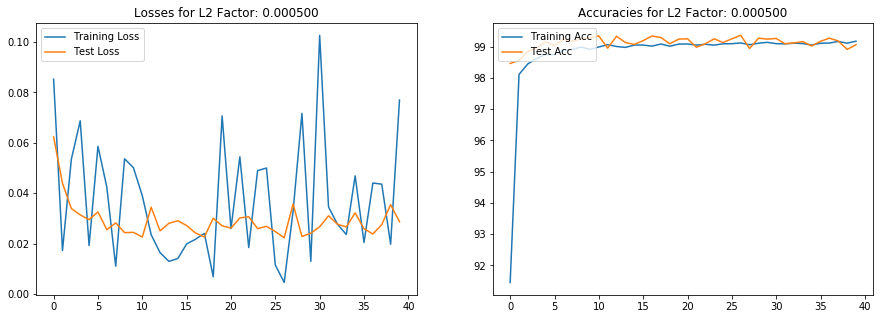

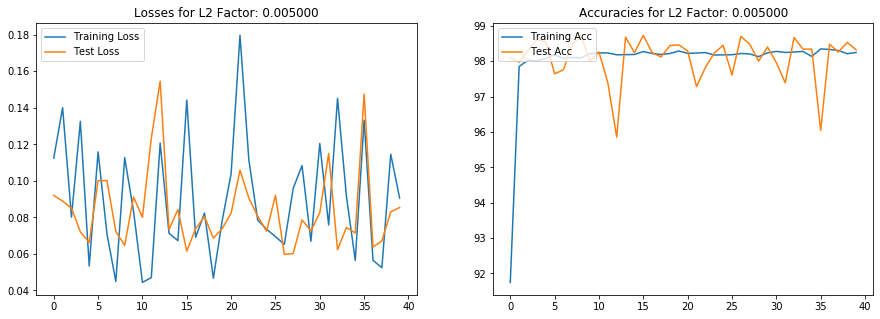

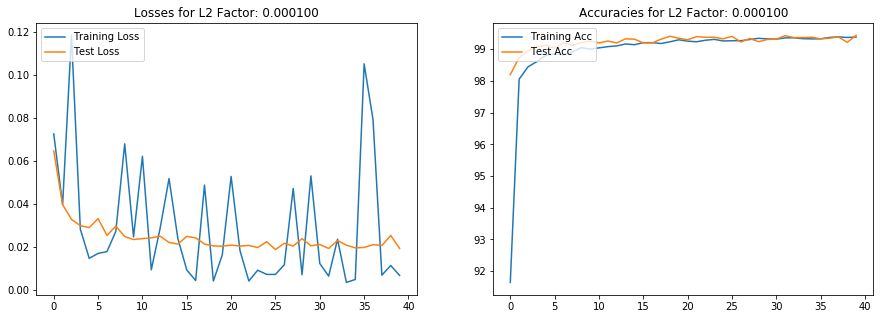

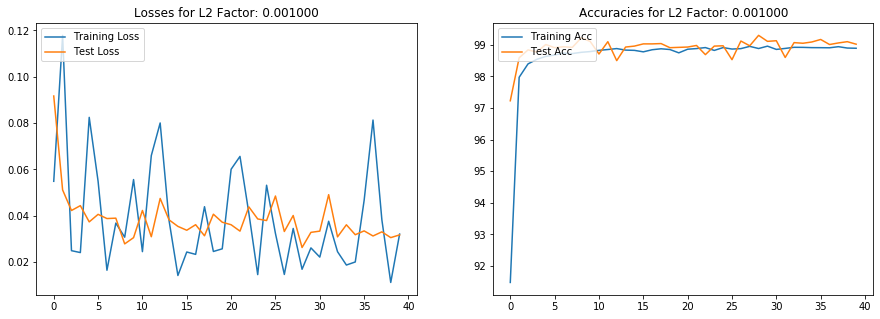

In [0]:
from torch.optim.lr_scheduler import StepLR
%matplotlib inline
import matplotlib.pyplot as plt

print('\n<<<<<<<< With L2 >>>>>>>>')
L1_Factor = 0
L2_Factor = [0.0005,0.005,0.0001,0.001]
for factor in L2_Factor:
    print('----------L2_Factor--------:',factor)
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    train_acc_epoch = []
    train_losses_epoch = []

    model =  Net().to(device)
    optimizer = optim.SGD(model.parameters(), lr=0.025, momentum=0.9,weight_decay=factor)    
    scheduler = StepLR(optimizer, step_size=6, gamma=0.1)

    EPOCHS = 40
    factor_in = L1_Factor
    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch, factor_in)
        test(model, device, test_loader)

    print('\nMaxium test accuracy: {:.2f}, Achieved in epoch: {}, Max Train accuracy : {:.2f}, Achieved in epoch : {}\n'.format(
           max(test_acc),  np.argmax(test_acc) , max(train_acc_epoch), np.argmax(train_acc_epoch))   )
    figure = plt.figure(figsize=(15,5))
    labels = ['Training Loss', 'Test Loss']

    plt.subplot(1,2,1)
    plt.title("Losses for L2 Factor: %f" %factor)
    plt.plot(train_losses_epoch,label=labels[0])
    plt.plot(test_losses,label=labels[1])
    plt.legend(loc="upper left")

    labels = ['Training Acc', 'Test Acc']
    plt.subplot(1,2,2)
    plt.title("Accuracies for L2 Factor: %f" %factor)
    plt.plot(train_acc_epoch,label=labels[0])
    plt.plot(test_acc,label=labels[1])
    plt.legend(loc="upper left")

In [0]:
actual_img_s1 = []
wrong_pred_s0 = []
wrong_pred_s1 = []
actual_target_s0 = []
actual_target_s1 = []
for i in range(len(actual_img)):
    if actual_img[i].shape[0] == 1:
      actual_img_s1.append(actual_img[i])
      wrong_pred_s0.append(wrong_pred[i].reshape(1))
      actual_target_s0.append(actual_target[i].reshape(1))

for i in range(len(wrong_pred_s0)):
  wrong_pred_s1.append(wrong_pred_s0[i][0])  # To reduce to 1 dimension
  actual_target_s1.append(actual_target_s0[i][0]) 

print('Total Actual Images that were misclassified:',len(actual_img))
print('Total wrong predictions:', len(wrong_pred))
print('Retained Actual Images that were misclassified:', len(actual_img_s1))
print('Retained wrong predictions:', len(wrong_pred_s1))

Total Actual Images that were misclassified: 12640
Total wrong predictions: 12640
Retained Actual Images that were misclassified: 4097
Retained wrong predictions: 4097


    7      0        4        4          2 

    5      0        7        4          7 

    1      4        3        0          0 

    0      7        2        7          3 

    2      8        2        4          2


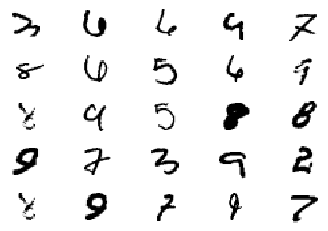

In [0]:
figure = plt.figure()
num_of_images = 25
i = 1
#figure = plt.figure(figsize=(15,15))
for index in range(1, num_of_images + 1):
          plt.subplot(5, 5, index)
          plt.axis('off')
          plt.imshow(actual_img_s1[index].reshape(28,28), cmap='gray_r') 

print('   ',wrong_pred_s1[1],'    ',wrong_pred_s1[2],'      ',wrong_pred_s1[3],'      ',wrong_pred_s1[4],'        ',wrong_pred_s1[5],'\n')
print('   ',wrong_pred_s1[6],'    ',wrong_pred_s1[7],'      ',wrong_pred_s1[8],'      ',wrong_pred_s1[9],'        ',wrong_pred_s1[10],'\n')
print('   ',wrong_pred_s1[11],'    ',wrong_pred_s1[12],'      ',wrong_pred_s1[13],'      ',wrong_pred_s1[14],'        ',wrong_pred_s1[15],'\n')
print('   ',wrong_pred_s1[16],'    ',wrong_pred_s1[17],'      ',wrong_pred_s1[18],'      ',wrong_pred_s1[19],'        ',wrong_pred_s1[20],'\n')
print('   ',wrong_pred_s1[21],'    ',wrong_pred_s1[22],'      ',wrong_pred_s1[23],'      ',wrong_pred_s1[24],'        ',wrong_pred_s1[25])

In [0]:
print ('    Actual Target Value in MNIST \n')
print('   ',actual_target_s1[1],'    ',actual_target_s1[2],'      ',actual_target_s1[3],'      ',actual_target_s1[4],'        ',actual_target_s1[5],'\n')
print('   ',actual_target_s1[6],'    ',actual_target_s1[7],'      ',actual_target_s1[8],'      ',actual_target_s1[9],'        ',actual_target_s1[10],'\n')
print('   ',actual_target_s1[11],'    ',actual_target_s1[12],'      ',actual_target_s1[13],'      ',actual_target_s1[14],'        ',actual_target_s1[15],'\n')
print('   ',actual_target_s1[16],'    ',actual_target_s1[17],'      ',actual_target_s1[18],'      ',actual_target_s1[19],'        ',actual_target_s1[20],'\n')
print('   ',actual_target_s1[21],'    ',actual_target_s1[22],'      ',actual_target_s1[23],'      ',actual_target_s1[24],'        ',actual_target_s1[25])

    Actual Target Value in MNIST 

    3      6        6        9          7 

    8      6        5        6          9 

    8      9        5        8          8 

    9      2        3        9          2 

    8      9        7        9          7
